# WFA Application to SOLIS/VSM Ca II 8542 Data (2016.07.15 17:29UT) ##

In [50]:
#
# import things we'll need
#

import numpy as np
import matplotlib.pyplot as mpl
import matplotlib.patches as patches
from astropy.io import fits
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
import wfa                          # note there are several smaller modules in here
import mask

#
# NOTE: to use the tqdm progress bars in this notebook, ensure you have run:
# $ pip3 install ipywidgets
# $ jupyter nbextension enable --py widgetsnbextension
#

In [51]:
#
# Read-in the Stokes I datacube (with header) ...let's take a look at some real metadata.
#

fitsi = fits.open( "k4vht160715t172912_i.fits" )
si    = fitsi[0].data
ihdr  = fitsi[0].header
ihdr

#
# Some important things to note:
#    SCANTIME --> exposure time per slit position, important for SNR considerations
#    CRPIX*   --> reference pixel for reference value along each axis
#    CRVAL*   --> reference value along each axis
#    CDELT*   --> change per pixel along each axis
#

SIMPLE  =                    T / Written by IDL:  Thu May  6 23:00:10 2021      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    3 / Number of data axes                            
NAXIS1  =                 2048 / Length of data axis 1 (columns)                
NAXIS2  =                 2048 / Length of data axis 2 (rows)                   
NAXIS3  =                  128 / Length of data axis 3 (planes)                 
EXTEND  =                    F / This file may contain extensions (T/F)         
COMMENT                                                                         
COMMENT ______________________ FITS File Content Keywords ______________________
COMMENT                                                                         
ORIGIN  = 'National Solar Observatory Integrated Synoptic Program (NISP)'       
DATE    = '2021-04-28T21:09:26'/ [YYYY-MM-DDThh:mm:ss] UTC file creation time   
VERSION = '1.0     '        

In [52]:
si.shape

#
# The FITS file has x = spatial E-W axis, y = spatial S-N axis, and z = wavelength axis...
# astropy.io.fits transposes these axes upon read-in (for some dumb reason)...must be careful with indexing!
#

(128, 2048, 2048)

In [53]:
#
# Let's fetch some geometry info about our dataset and calculate our observed wavelengths...
#

nx    = ihdr[ "NAXIS1" ]    # dataset size
ny    = ihdr[ "NAXIS2" ]
nw    = ihdr[ "NAXIS3" ]

xdc   = ihdr[ "CRPIX1" ]    # approx. disc-center coordinates [pixels]
ydc   = ihdr[ "CRPIX2" ]
r0    = ihdr[ "IMG_R0" ]    # approx. solar radius [pixels]

wpix  = ihdr[ "CRPIX3" ]    # standard FITS axis coordinate specifiers for wavelength axis 
wval  = ihdr[ "CRVAL3" ]
wstep = ihdr[ "CDELT3" ]
wobs  = 10.*( wval + wstep*(np.arange(0,nw) - wpix) )    # in Angstroms

wobs.min(), wobs.max()

(8539.73845, 8544.373950000001)

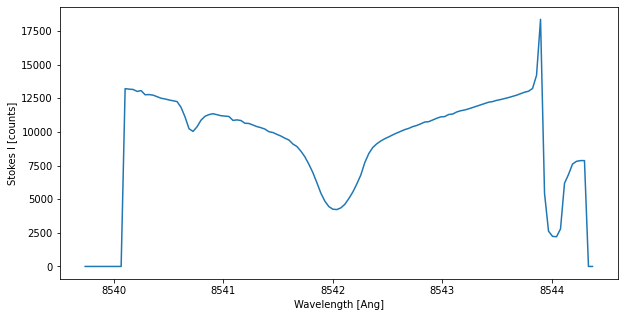

In [54]:
#
# OK, let's take a look at a representative Stokes I profile
#

s = 1024    # scanline
p = 1024    # pixel

mpl.figure( figsize=[10,5] )
mpl.ylabel( "Stokes I [counts]" )
mpl.xlabel( "Wavelength [Ang]" )

mpl.plot( wobs, si[:,s,p] )  # display all wavelengths...note the vagaries of REAL data
                             # (illumination edge effects, spurious intensities, no continuum)!

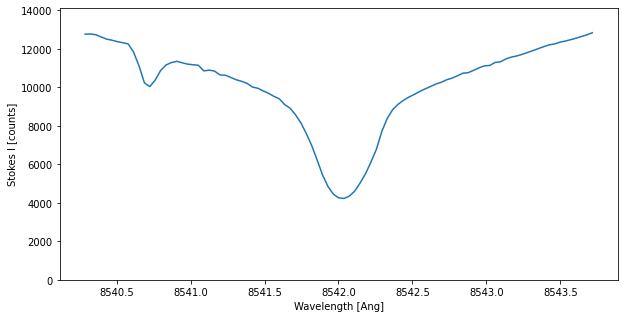

In [55]:
#
# Let's restrict the wavelength range to avoid including suspect data in our analyses...
#

ws = 15    # starting wavelength index
we = 110   # ending wavelength index

fig, (ax1) = mpl.subplots( 1, figsize=[10,5] )
ax1.set_ylabel( "Stokes I [counts]" )
ax1.set_xlabel( "Wavelength [Ang]" )
ax1.set_ylim( [0, 1.1*np.max(si[ws:we,s,p])] )
ax1.plot( wobs[ws:we], si[ws:we,s,p] )

#
# Note the slight asymmetry of the line-core...this has contributions from different plasma
# velocities co-existing in the same pixel, as well as from Ca isotopes
# (see e.g. Leenaarts et. al., ApjL, 784, L17)
#

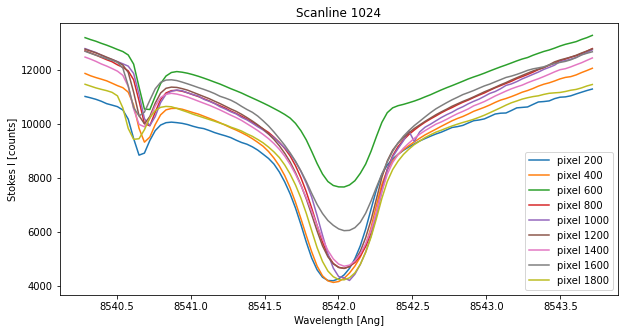

In [56]:
#
# OK, let's take a look at several different Stokes I profiles across this scanline...
# comments on the various line-shapes?
#

mpl.figure( figsize=[10,5] )
mpl.ylabel( "Stokes I [counts]" )
mpl.xlabel( "Wavelength [Ang]" )
mpl.title( "Scanline "+str(s) )

for i in range(1,10):
    mpl.plot( wobs[ws:we], si[ws:we,s,i*200], label='pixel '+str(i*200) ) 

mpl.legend()

In [57]:
#
# Now read-in the Stokes QUV datacubes (with headers)
#

fitsq = fits.open( "k4vht160715t172912_q.fits" )
sq    = fitsq[0].data
qhdr  = fitsq[0].header

fitsu = fits.open( "k4vht160715t172912_u.fits" )
su    = fitsu[0].data
uhdr  = fitsu[0].header

fitsv = fits.open( "k4vht160715t172912_v.fits" )
sv    = fitsv[0].data
vhdr  = fitsv[0].header

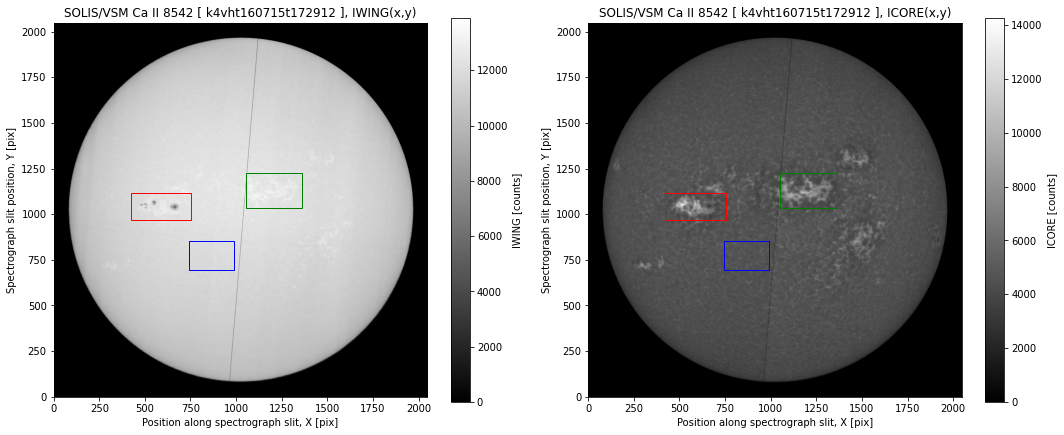

In [58]:
#
# What does the solar disc look like for this dataset (wing & core intensity images)?
#

obsprefix = "SOLIS/VSM Ca II 8542 [ k4vht160715t172912 ]"
ylabel    = "Spectrograph slit position, Y [pix]"
xlabel    = "Position along spectrograph slit, X [pix]"

fig, (ax1, ax2) = mpl.subplots( nrows=1, ncols=2, figsize=[15,10] )

ax1.set_title( obsprefix + ", IWING(x,y)" )
ax1.set_xlabel( xlabel )
ax1.set_ylabel( ylabel )
im1   = ax1.imshow( si[20,:,:], origin="lower", cmap="gray" )  # Note the use of origin="lower" to display the data
cbar1 = mpl.colorbar( im1, ax=ax1, shrink=0.55 )               # as it appears in the original FITS file, instead
cbar1.set_label( "IWING [counts]")                             # of how python wants to display it (i.e., in 
                                                               # "matrix" form)

ax2.set_title( obsprefix + ", ICORE(x,y)" )
ax2.set_xlabel( xlabel )
ax2.set_ylabel( ylabel )
im2   = ax2.imshow( si[64,:,:], origin="lower", cmap="gray" )
cbar2 = mpl.colorbar( im2, ax=ax2, shrink=0.55 )
cbar2.set_label( "ICORE [counts]")

#
# let's highlight some features of interest (Active Region, Plage, Quiet-Sun):
#

ar = [  422,  752,  966, 1116 ]        # [x1,x2,y1,y2] bounding box
pl = [ 1052, 1360, 1036, 1226 ]
qs = [  742,  990,  692,  850 ]

for ax in (ax1, ax2):
    rect1 = patches.Rectangle( (ar[0],ar[2]), ar[1]-ar[0]+1, ar[3]-ar[2]+1, edgecolor='r', facecolor='none' )
    rect2 = patches.Rectangle( (pl[0],pl[2]), pl[1]-pl[0]+1, pl[3]-pl[2]+1, edgecolor='g', facecolor='none' )
    rect3 = patches.Rectangle( (qs[0],qs[2]), qs[1]-qs[0]+1, qs[3]-qs[2]+1, edgecolor='b', facecolor='none' )
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)

mpl.tight_layout( )
mpl.show( )

icont_od =  11553.554
icore_od =  4432.6436
icont_dc =  12776.234
icore_dc =  4745.5767


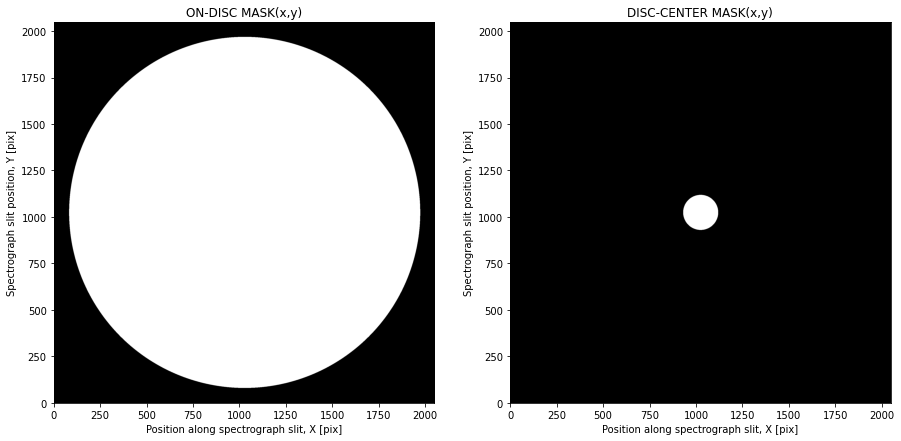

In [59]:
#
# Let's calculate some average disc-center data metrics...we won't really use these in this notebook, but
# they can be useful for normalization and data visualization (play around with this if you want)
#

icont    = np.squeeze( si[ws,:,:] )  # this is actually a wing intensity but for practical purposes we can
                                     # call this a pseudo-continuum intensity

icore    = np.squeeze( si[64,:,:] )  # np.squeeze eliminates dimensions of size 1

odmask   = mask.circular( ny, nx, center=(xdc,ydc), radius=r0 )
icont_od = np.mean( icont[odmask] )
icore_od = np.mean( icore[odmask] )
print( "icont_od = ", icont_od )
print( "icore_od = ", icore_od )

dcmask   = mask.circular( ny, nx, center=(xdc,ydc), radius=0.1*r0 )
icont_dc = np.mean( icont[dcmask] )
icore_dc = np.mean( icore[dcmask] )
print( "icont_dc = ", icont_dc )
print( "icore_dc = ", icore_dc )

fig, (ax1, ax2) = mpl.subplots( nrows=1, ncols=2, figsize=[15,10] )

ax1.set_title( "ON-DISC MASK(x,y)" )
ax1.set_xlabel( xlabel )
ax1.set_ylabel( ylabel )
im1   = ax1.imshow( odmask, origin="lower", cmap="gray" )

ax2.set_title( "DISC-CENTER MASK(x,y)" )
ax2.set_xlabel( xlabel )
ax2.set_ylabel( ylabel )
im2   = ax2.imshow( dcmask, origin="lower", cmap="gray" )

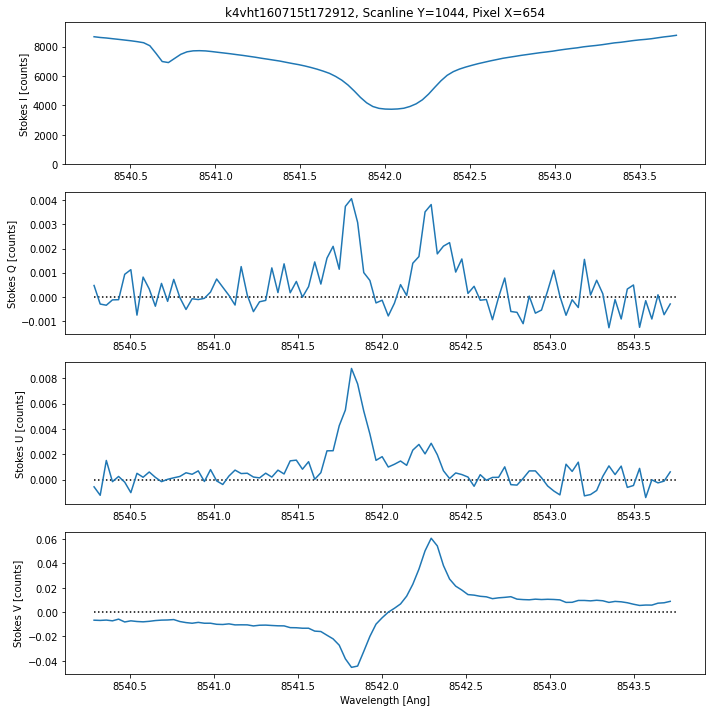

In [60]:
#
# OK, let's get to some more interesting stuff and take a look at some Ca II 8542
# Stokes IQUV spectra in a sunspot...the QUV profiles are normalized to the Stokes I
# pseudo-continuum
#

s = 1044    # scanline
p = 654     # pixel

fig, (ax1, ax2, ax3, ax4) = mpl.subplots( 4, figsize=[10,10] )

ax1.set_title( 'k4vht160715t172912, Scanline Y={}, Pixel X={}'.format(s,p) )
ax1.set_ylabel( "Stokes I [counts]" )
ax1.set_ylim( [0, 1.1*np.max(si[ws:we,s,p])] )
ax1.plot( wobs[ws:we], si[ws:we,s,p] )

ax2.set_ylabel( "Stokes Q [counts]" )
ax2.plot( wobs[ws:we], sq[ws:we,s,p]/np.max(si[ws:we,s,p]) )
ax2.hlines( 0, wobs[ws], wobs[we], linestyle="dotted" )

ax3.set_ylabel( "Stokes U [counts]" )
ax3.plot( wobs[ws:we], su[ws:we,s,p]/np.max(si[ws:we,s,p])  )
ax3.hlines( 0, wobs[ws], wobs[we], linestyle="dotted" )

ax4.set_xlabel( "Wavelength [Ang]" )
ax4.set_ylabel( "Stokes V [counts]" )
ax4.plot( wobs[ws:we], sv[ws:we,s,p]/np.max(si[ws:we,s,p])  )
ax4.hlines( 0, wobs[ws], wobs[we], linestyle="dotted" )

mpl.tight_layout( )
mpl.show( )

#
# So, note that even in a strong sunspot the Stokes V signal is only ~ 6% of the maximum Stokes I 
# signal, and Stokes Q and U are well below 1%.
#
# Note that Stokes V never falls to zero in the far wings...this is a very broad line, and
# SOLIS/VSM does not observe continuum wavelengths in this band, due to prefilter truncation
# and limited spectral dispersion on the CCD.
#

In [61]:
#
# OK, let's calculate some different measures of the central line-core wavelength...
#

lam0 = wfa.calc_lam0_cog( np.squeeze(si[ws:we,s,p]), wobs[ws:we], 8542.0910 )
print( "lam0[s,p]    =", lam0, "Ang" )

lam0_zc = wfa.calc_lam0_vzc( np.squeeze(sv[ws:we,s,p]), wobs[ws:we], 8542.0910 )
print( "lam0_zc[s,p] =", lam0_zc, "Ang" )

#
# So, we have a difference between these two values of about 0.03 Angstroms, which translates to
# a velocity difference of about 1 km/sec...why might these values be different when calculated from
# unpolarized vs. polarized spectra?
#

lam0[s,p]    = 8542.072331752577 Ang
lam0_zc[s,p] = 8542.039276216177 Ang


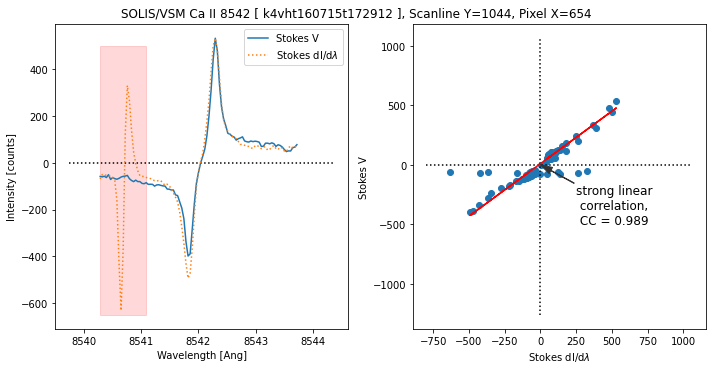

In [66]:
#
# Now, let's delve into the Weak-Field Approximation (WFA) by looking at Stokes dI/dLam vs Stokes V...
# this is the basis of the WFA for calculating BLOS.
#

dii_dLam = np.gradient( np.squeeze(si[ws:we,s,p]), wobs[ws:we], edge_order=2 )
vv       = np.squeeze(sv[ws:we,s,p])

fig, (ax1, ax2) = mpl.subplots( nrows=1, ncols=2, figsize=[10,5] )
fig.suptitle( obsprefix + ", Scanline Y={}, Pixel X={}".format(s,p), y=1.02 )

ratio    = np.max(abs(vv))/np.max(dii_dLam)
dii_dLam = ratio*dii_dLam    # this re-scaling is for display only (to show the proportionality)...
                             # the actual ratio tells you about the value of BLOS.

ax1.set_xlabel( "Wavelength [Ang]" )
ax1.set_ylabel( "Intensity [counts]" )
ax1.plot( wobs[ws:we], vv, label="Stokes V" )
ax1.plot( wobs[ws:we], dii_dLam, linestyle="dotted", label=r'Stokes dI/d$\lambda$' )
ax1.hlines( 0, np.min(wobs), np.max(wobs), linestyle="dotted" )
rect1 = patches.Rectangle( (wobs[ws],-650), wobs[ws+22]-wobs[ws], 1150, edgecolor='r', facecolor='red', alpha=0.15 )
ax1.add_patch( rect1 )
ax1.legend( )

ax2.set_xlabel( r'Stokes dI/d$\lambda$' )
ax2.set_ylabel( 'Stokes V' )
ax2.scatter( dii_dLam, vv )
ax2.hlines( 0, 2*np.min(vv), 2*np.max(vv), linestyle="dotted" )
ax2.vlines( 0, 2*np.min(dii_dLam), 2*np.max(dii_dLam), linestyle="dotted" )

coeff   = np.polyfit( dii_dLam[22:], vv[22:], 1 ) # we exclude the telluric line from the analysis
                                                  # (everything interior to the semi-transparent red rectangle)

fit     = np.polyval( coeff, dii_dLam[22:] )
corr, _ = pearsonr( dii_dLam[22:], vv[22:] )
cc      = '%.3f'%(corr)

ax2.plot( dii_dLam[22:], fit, color="r" )
ax2.annotate('strong linear\n correlation,\n CC = '+cc, xy=(0, 0), xytext=(250, -500), fontsize=12, 
             arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})

mpl.tight_layout( )
mpl.show( )

In [14]:
#
# OK, let's define some wavelength ranges of interest for the WFA (in Angstroms, from nominal line-center)...
#

corepos = [ 0.00, 0.25 ]      # line-core position
cwbypos = [ 0.10, 0.40 ]      # core-wing boundary position (the "elbows" of the Stokes I profile)
wingpos = [ 0.75, 1.25 ]      # wing position (must ensure that this range excludes bad edge data, if applicable)

lc_dist = abs( wobs - lam0 )  # defines the absolute wavelength offset scale
lc_dist.min(), lc_dist.max()

(0.002118247422913555, 2.333881752576417)

In [15]:
#
# Extract the Stokes IQUV profiles for the current scanline and pixel
#

data      = np.zeros( (4, 128) )
data[0,:] = np.squeeze( si[:,s,p] )
data[1,:] = np.squeeze( sq[:,s,p] )
data[2,:] = np.squeeze( su[:,s,p] )
data[3,:] = np.squeeze( sv[:,s,p] )

#
# Extract (non-normalized) data from the core of the line
#

core_count, core_wave, core_data, core_deriv = wfa.extract_range( data, wobs, lc_dist, corepos )
core_count, core_wave, core_data, core_deriv    # just a sanity check...

(13,
 array([8541.85545, 8541.89195, 8541.92845, 8541.96495, 8542.00145,
        8542.03795, 8542.07445, 8542.11095, 8542.14745, 8542.18395,
        8542.22045, 8542.25695, 8542.29345]),
 array([[ 4.55019141e+03,  4.18299463e+03,  3.93192578e+03,
          3.80521313e+03,  3.75797632e+03,  3.74688940e+03,
          3.76533203e+03,  3.81348828e+03,  3.93482837e+03,
          4.11495654e+03,  4.38581348e+03,  4.77347363e+03,
          5.23421973e+03],
        [ 2.70176716e+01,  8.79755592e+00,  5.93306351e+00,
         -2.23452353e+00, -1.24996734e+00, -6.96754217e+00,
         -2.36058664e+00,  4.41603994e+00,  4.57669050e-01,
          1.21892176e+01,  1.46158686e+01,  3.08446007e+01,
          3.35237770e+01],
        [ 6.62083054e+01,  4.74376030e+01,  3.15957680e+01,
          1.33511639e+01,  1.58987370e+01,  8.72746563e+00,
          1.06280422e+01,  1.28825331e+01,  9.89780521e+00,
          2.04115067e+01,  2.43485088e+01,  1.78160534e+01,
          2.51552773e+01],
        [-3.

In [16]:
#
# Similarly, extract data from the core/wing boundary and wing of the line...
#

cwby_count, cwby_wave, cwby_data, cwby_deriv = wfa.extract_range( data, wobs, lc_dist, cwbypos )
wing_count, wing_wave, wing_data, wing_deriv = wfa.extract_range( data, wobs, lc_dist, wingpos )

In [17]:
#
# OK, let's get down to business and calculate the Weak-Field Approximation (WFA) magnetic
# field for this single pixel!
#

glos_eff = 1.1                  # Lande g-factors for Ca II 8542
gtrn_eff = 1.205 

kfac  = 4.6686E-13*(lam0**2)    # some proportionality constants for WFA analysis
c_los = kfac*glos_eff
c_trn = (kfac**2)*gtrn_eff

#
# LOS field strength [G]
#
blos  = wfa.wfa_blos( core_data, core_wave, core_deriv, c_los )

#
# Transverse field strength [G]
#
btrn  = wfa.wfa_btrn( cwby_data, cwby_wave, cwby_deriv, c_trn, lam0 )

#
# Total field strength [G]
#
bfld  = np.sqrt( blos**2 + btrn**2 )

#
# LOS field inclination [deg] with 0 = parallel to LOS and 180 = anti-parallel to LOS
#
binc  = wfa.wfa_binc( blos, btrn )

#
# Transverse field azimuth [deg] with 0 = +y direction (N) and 180 = -y direction (S)
# (Note that this convention is specific to SOLIS/VSM instrument orientation, and
# other datasets/instruments may have their own reference direction)
#
bazm  = wfa.wfa_bazm( core_data )

print( "blos = ", blos, "G" )
print( "btrn = ", btrn, "G" )
print( "bfld = ", bfld, "G" )
print( "binc = ", binc, "deg" )
print( "bazm = ", bazm, "deg" )

#
#
# GC: Comment. In both wfa_blos & wfa_btrn the strict proportionality between V and dI/dl is assumed, but not
#     verified. Should we discuss this somehow?
#
#
#     WHAT DO YOU WANT TO DISCUSS ABOUT THIS?
#
#  this is real data, so not as clean as synthetic data...
#  assume y-intercept of proportionality is zero, but not verified...
#  PERHAPS LEFT AS AN EXERCISE FOR THE STUDENTS IF THEY WANT TO PLAY AROUND WITH IT
#


blos =  -982.4164928648215 G
btrn =  916.7126873195775 G
bfld =  1343.6905583301154 G
binc =  136.98146071022097 deg
bazm =  123.83741556986764 deg


In [18]:
#
# OK, let's extend this exercise to calculate WFA magnetic fields in a selected sub-FOV (Active Region)?
# Note that everything we've so far done manually for the single-pixel case is wrapped-up in the 
# wfa.wfapprox function...
#

nx = ar[1] - ar[0] + 1
ny = ar[3] - ar[2] + 1

ar_lam0   = np.zeros( (ny,nx) )    # we will look at these maps below
ar_lam0zc = np.zeros( (ny,nx) )

ar_blos = np.zeros( (ny,nx) )
ar_btrn = np.zeros( (ny,nx) )
ar_binc = np.zeros( (ny,nx) )
ar_bazm = np.zeros( (ny,nx) )

lam0_nom = 8542.0910               # nominal line-core wavelength [Ang]

for y in tqdm(range(0,ny)):        # tqdm just displays a progress bar for an iterable.
    scan = ar[2] + y
    for x in range(0,nx):
        pix       = ar[0] + x
        data[0,:] = np.squeeze( si[:,scan,pix] )
        data[1,:] = np.squeeze( sq[:,scan,pix] )
        data[2,:] = np.squeeze( su[:,scan,pix] )
        data[3,:] = np.squeeze( sv[:,scan,pix] )
    
        ar_lam0[y,x]   = wfa.calc_lam0_cog( np.squeeze(data[0,ws:we]), wobs[ws:we], lam0_nom )
        ar_lam0zc[y,x] = wfa.calc_lam0_vzc( np.squeeze(data[3,ws:we]), wobs[ws:we], lam0_nom )
        
        wfaparms     = wfa.wfapprox( data, wobs, glos_eff, gtrn_eff, ar_lam0[y,x] )
        ar_blos[y,x] = wfaparms[1]
        ar_btrn[y,x] = wfaparms[2]
        ar_binc[y,x] = wfaparms[4]
        ar_bazm[y,x] = wfaparms[5]
    pass

#
# The wfa.wfapprox function can also calculate also the photospheric field from the line wings...we
# will come back to this in a later exercise below.
#

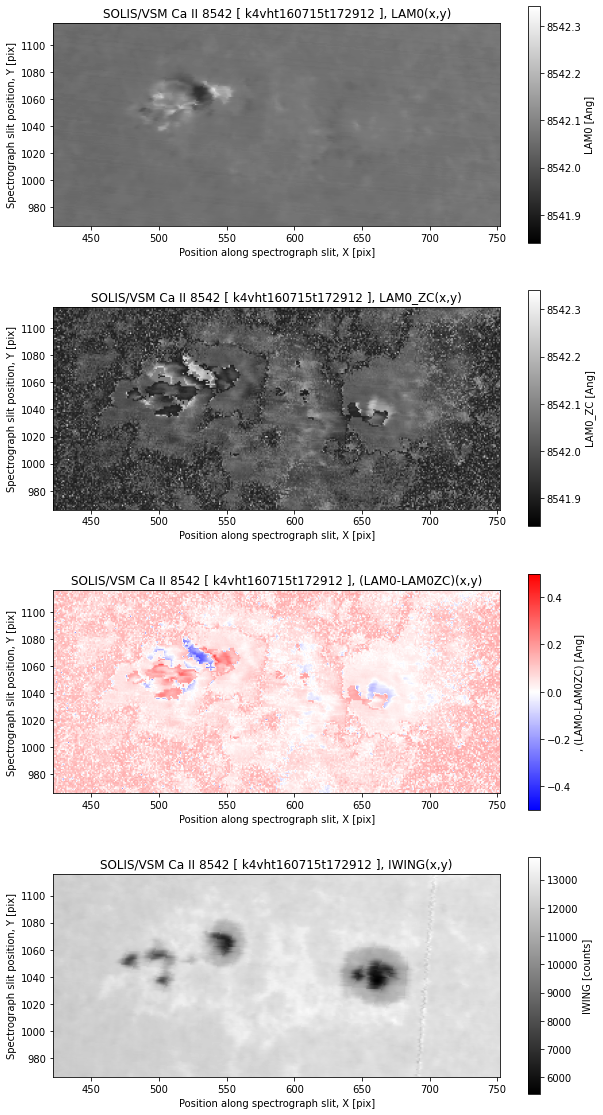

In [19]:
#
# First, let's take a look at the CoG- and ZC-derived line-core wavelength maps...
#

fig, (ax1, ax2, ax3, ax4) = mpl.subplots( 4, figsize=[10,20] )

ax1.set_title( obsprefix + ", LAM0(x,y)" )
ax1.set_xlabel( xlabel )
ax1.set_ylabel( ylabel )
im1   = ax1.imshow( ar_lam0, origin="lower", cmap="gray", vmin=lam0_nom-0.25, vmax=lam0_nom+0.25, extent=ar )
cbar1 = mpl.colorbar( im1, ax=ax1 )
cbar1.set_label( "LAM0 [Ang]")

ax2.set_title( obsprefix + ", LAM0_ZC(x,y)" )
ax2.set_xlabel( xlabel )
ax2.set_ylabel( ylabel )
im2   = ax2.imshow( ar_lam0zc, origin="lower", cmap="gray", vmin=lam0_nom-0.25, vmax=lam0_nom+0.25, extent=ar )
cbar2 = mpl.colorbar( im2, ax=ax2 )
cbar2.set_label( "LAM0_ZC [Ang]")

ax3.set_title( obsprefix + ", (LAM0-LAM0ZC)(x,y)" )
ax3.set_xlabel( xlabel )
ax3.set_ylabel( ylabel )
im3   = ax3.imshow( ar_lam0-ar_lam0zc, origin="lower", cmap="bwr", vmin=-0.5, vmax=0.5, extent=ar )
cbar3 = mpl.colorbar( im3, ax=ax3 )
cbar3.set_label( ", (LAM0-LAM0ZC) [Ang]" )

ax4.set_title( obsprefix + ", IWING(x,y)" )
ax4.set_xlabel( xlabel )
ax4.set_ylabel( ylabel )
im4   = ax4.imshow( np.squeeze(si[15,ar[2]:ar[3],ar[0]:ar[1]]), origin="lower", cmap="gray", extent=ar )
cbar4 = mpl.colorbar( im4, ax=ax4 )
cbar4.set_label( "IWING [counts]")

mpl.show( )

#
# QUESTION: What might cause the difference between lam0 values derived from Stokes I vs Stokes V?
#           Could there be differences between co-existing atmospheres that differentially manifest in
#           unpolarized vs polarized spectra?  Do we expect fully-resolved fields at arc-second spatial
#           resolutions?
#

#
# Note that the extremes in lam0-lam0zc (in and around the spots) would correspond to fairly high flows
# of ~ 10 km/s. Is this physically reasonable, or perhaps due to a limitation of the method(s) when
# Stokes V has complicated structure in the line-core (i.e. multiple zero-crossings) and/or when Stokes I
# line-core is flat or in emission...must watch out for these edge cases!
#

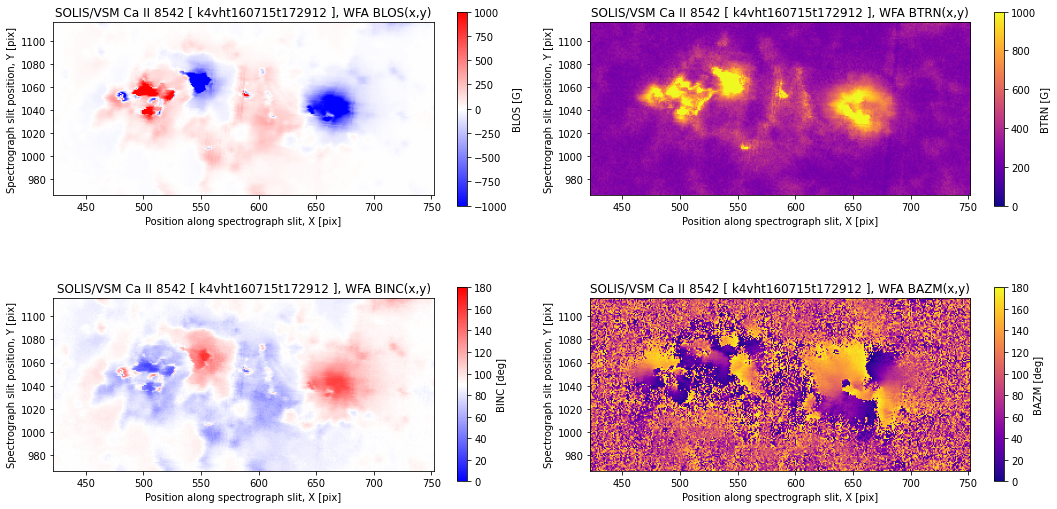

In [20]:
#
# OK, now let's take a look at the WFA results (Active Region)!
#

fig, ((ax1, ax2), (ax3, ax4)) = mpl.subplots( 2, 2, figsize=[15,8] )

ax1.set_title( obsprefix + ", WFA BLOS(x,y)" )
ax1.set_xlabel( xlabel )
ax1.set_ylabel( ylabel )
im1   = ax1.imshow( ar_blos, origin="lower", cmap="bwr", vmin=-1000, vmax=1000, extent=ar )
cbar1 = mpl.colorbar( im1, ax=ax1, shrink=0.7 )
cbar1.set_label( "BLOS [G]") 

ax2.set_title( obsprefix + ", WFA BTRN(x,y)" )
ax2.set_xlabel( xlabel )
ax2.set_ylabel( ylabel )
im2   = ax2.imshow( ar_btrn, origin="lower", cmap="plasma", vmin=0, vmax=1000, extent=ar )
cbar2 = mpl.colorbar( im2, ax=ax2, shrink=0.7 )
cbar2.set_label( "BTRN [G]") 

ax3.set_title( obsprefix + ", WFA BINC(x,y)" )
ax3.set_xlabel( xlabel )
ax3.set_ylabel( ylabel )
im3   = ax3.imshow( ar_binc, origin="lower", cmap="bwr", vmin=0, vmax=180, extent=ar )
cbar3 = mpl.colorbar( im3, ax=ax3, shrink=0.7 )
cbar3.set_label( "BINC [deg]") 

ax4.set_title( obsprefix + ", WFA BAZM(x,y)" )
ax4.set_xlabel( xlabel )
ax4.set_ylabel( ylabel )
im4   = ax4.imshow( ar_bazm, origin="lower", cmap="plasma", vmin=0, vmax=180, extent=ar )
cbar4 = mpl.colorbar( im4, ax=ax4, shrink=0.7 )
cbar4.set_label( "BAZM [deg]") 

mpl.tight_layout( )
mpl.show( )

#
# QUESTION: Notice the sharp boundaries in some parts of the Active region...why does the method 
#           seem to struggle there?
#           (...what does the "W" stand for in "WFA"?)
#

#
# Note the scale of the azimuth is between [0,180] degrees and wraps-around...we do not resolve
# the 180-degree ambiguity inherent in magnetic field diagnostics from Zeeman-induced polarization
# signatures here.  This is a complex topic that deserves its own entire workshop.
#

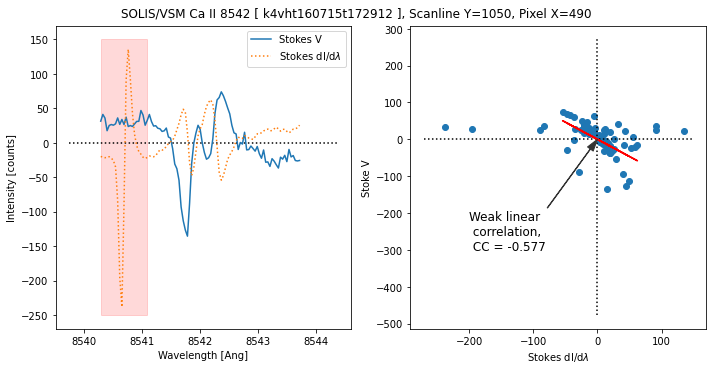

In [67]:
#
# Well, let's have a look at Stokes dI/dLam vs Stokes V in one of these "sharp boundary" pixels
# to see why the method might be failing...
#

sfail = 1050
pfail = 490

dii_dLam = np.gradient( np.squeeze(si[ws:we,sfail,pfail]), wobs[ws:we], edge_order=2 )
vv       = np.squeeze(sv[ws:we,sfail,pfail])

fig, (ax1, ax2) = mpl.subplots( nrows=1, ncols=2, figsize=[10,5] )
fig.suptitle( obsprefix + ", Scanline Y={}, Pixel X={}".format(sfail,pfail), y=1.02 )

ratio    = np.max(abs(vv))/np.max(dii_dLam)
dii_dLam = ratio*dii_dLam

ax1.set_xlabel( "Wavelength [Ang]" )
ax1.set_ylabel( "Intensity [counts]" )
ax1.plot( wobs[ws:we], vv, label="Stokes V" )
ax1.plot( wobs[ws:we], dii_dLam, linestyle="dotted", label=r'Stokes dI/d$\lambda$' )
ax1.hlines( 0, np.min(wobs), np.max(wobs), linestyle="dotted" )
rect1 = patches.Rectangle( (wobs[ws],-250), wobs[ws+22]-wobs[ws], 400, edgecolor='r', facecolor='red', alpha=0.15 )
ax1.add_patch( rect1 )
ax1.legend( )

ax2.set_xlabel( r'Stokes dI/d$\lambda$' )
ax2.set_ylabel( 'Stoke V' )
ax2.scatter( dii_dLam, vv )
ax2.hlines( 0, 2*np.min(vv), 2*np.max(vv), linestyle="dotted" )
ax2.vlines( 0, 2*np.min(dii_dLam), 2*np.max(dii_dLam), linestyle="dotted" )

coeff   = np.polyfit( dii_dLam[22:], vv[22:], 1 )    # again, exclude the telluric line-region

fit     = np.polyval( coeff, dii_dLam[22:] )
corr, _ = pearsonr( dii_dLam[22:], vv[22:] )
cc      = '%.3f'%(corr)
ax2.plot( dii_dLam[22:], fit, color="r" )
ax2.annotate('Weak linear\n correlation, \n CC = '+cc, xy=(0, 0), xytext=(-200, -300), fontsize=12, 
             arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})

mpl.tight_layout( )
mpl.show( )

<Figure size 720x720 with 0 Axes>

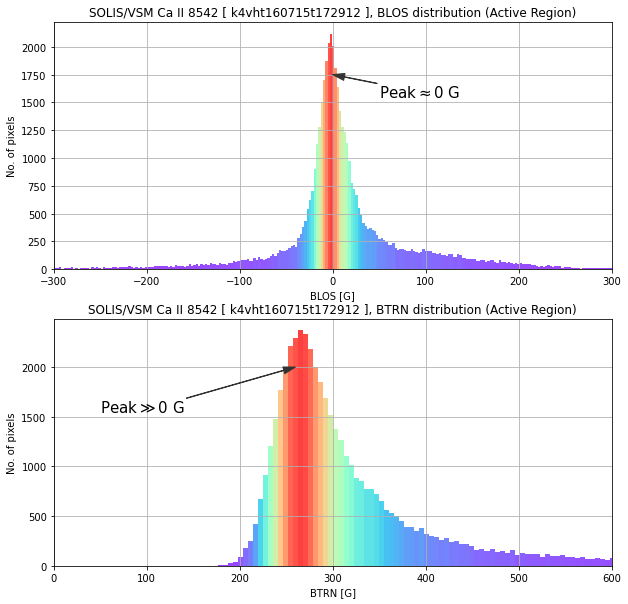

In [22]:
#
# OK, let's keep going and examine the distribution of WFA magnetic fields in the Active Region...
#

mpl.figure( figsize=[10,10] )

fig, (ax1, ax2) = mpl.subplots( 2, figsize=[10,10] )

n,bins,patches = ax1.hist( ar_blos.flatten(), bins="auto", align="mid", alpha=0.75 )
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(mpl.cm.rainbow(n[i]/max(n)))
ax1.annotate(r'Peak$\approx$0 G', xy=(0.0, 1750), xytext=(50, 1550), fontsize=15, 
             arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})
ax1.set_xlim( -300, 300 )
ax1.set_title( obsprefix + ", BLOS distribution (Active Region)" )
ax1.set_xlabel( "BLOS [G]" )
ax1.set_ylabel( "No. of pixels" )
ax1.grid( True )

n,bins,patches = ax2.hist( ar_btrn.flatten(), bins="auto", align="mid", alpha=0.75 )
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(mpl.cm.rainbow(n[i]/max(n)))
ax2.annotate(r'Peak$\gg$0 G', xy=(260, 2000), xytext=(50, 1550), fontsize=15, 
             arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})
ax2.set_xlim( 0, 600 )
ax2.set_title( obsprefix + ", BTRN distribution (Active Region)" )
ax2.set_xlabel( "BTRN [G]" )
ax2.set_ylabel( "No. of pixels" )
ax2.grid( True )

mpl.show( )

#
# QUESTION: Why does there appear to be a floor in BTRN values, with a peak at values >> 0?
#           NOTE: chromospheric fields may not be much larger than our floor...
#

In [23]:
#
# OK, let's calculate and examine the fields in another region (Plage)...
#

nx = pl[1] - pl[0] + 1
ny = pl[3] - pl[2] + 1

pl_lam0 = np.zeros( (ny,nx) )
pl_blos = np.zeros( (ny,nx) )
pl_btrn = np.zeros( (ny,nx) )
pl_binc = np.zeros( (ny,nx) )
pl_bazm = np.zeros( (ny,nx) )

for y in tqdm(range(0,ny)):
    scan = pl[2] + y
    for x in range(0,nx):
        pix       = pl[0] + x
        data[0,:] = np.squeeze( si[:,scan,pix] )
        data[1,:] = np.squeeze( sq[:,scan,pix] )
        data[2,:] = np.squeeze( su[:,scan,pix] )
        data[3,:] = np.squeeze( sv[:,scan,pix] )
        
        lam0         = wfa.calc_lam0_cog( np.squeeze(data[0,ws:we]), wobs[ws:we], lam0_nom )
        wfaparms     = wfa.wfapprox( data, wobs, glos_eff, gtrn_eff, lam0 )
        pl_blos[y,x] = wfaparms[1]
        pl_btrn[y,x] = wfaparms[2]
        pl_binc[y,x] = wfaparms[4]
        pl_bazm[y,x] = wfaparms[5]
        pl_lam0[y,x] = lam0
    pass

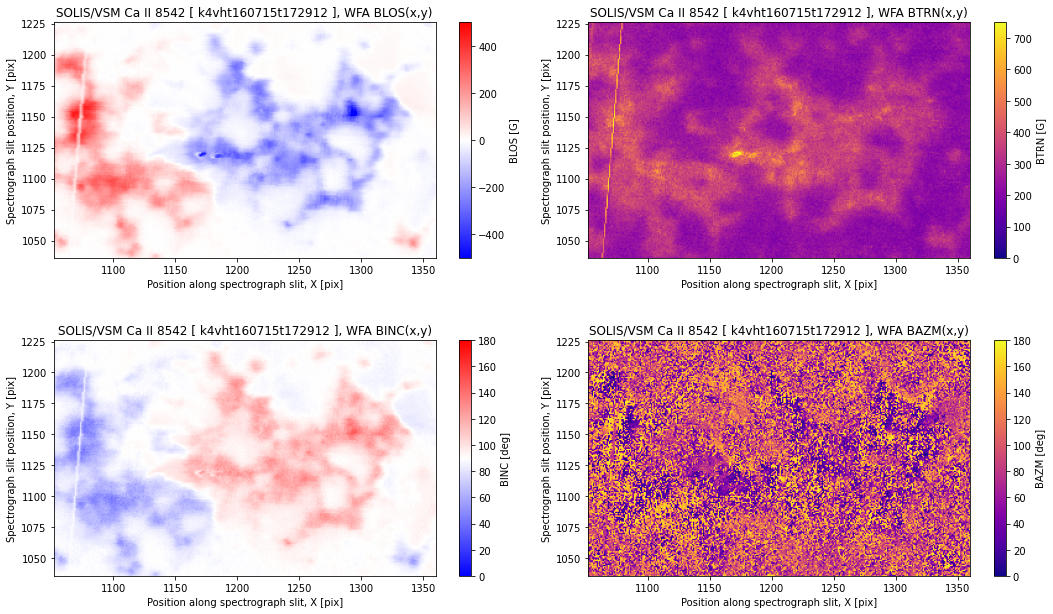

In [24]:
#
# Now let's take a look at the WFA results (Plage)!
#

fig, ((ax1, ax2), (ax3, ax4)) = mpl.subplots( 2, 2, figsize=[15,9] )

ax1.set_title( obsprefix + ", WFA BLOS(x,y)" )
ax1.set_xlabel( xlabel )
ax1.set_ylabel( ylabel )
im1   = ax1.imshow( pl_blos, origin="lower", cmap="bwr", vmin=-500, vmax=500, extent=pl )
cbar1 = mpl.colorbar( im1, ax=ax1, shrink=0.8 )
cbar1.set_label( "BLOS [G]") 

ax2.set_title( obsprefix + ", WFA BTRN(x,y)" )
ax2.set_xlabel( xlabel )
ax2.set_ylabel( ylabel )
im2   = ax2.imshow( pl_btrn, origin="lower", cmap="plasma", vmin=0, vmax=750, extent=pl )
cbar2 = mpl.colorbar( im2, ax=ax2, shrink=0.8 )
cbar2.set_label( "BTRN [G]") 

ax3.set_title( obsprefix + ", WFA BINC(x,y)" )
ax3.set_xlabel( xlabel )
ax3.set_ylabel( ylabel )
im3   = ax3.imshow( pl_binc, origin="lower", cmap="bwr", vmin=0, vmax=180, extent=pl )
cbar3 = mpl.colorbar( im3, ax=ax3, shrink=0.8 )
cbar3.set_label( "BINC [deg]") 

ax4.set_title( obsprefix + ", WFA BAZM(x,y)" )
ax4.set_xlabel( xlabel )
ax4.set_ylabel( ylabel )
im4   = ax4.imshow( pl_bazm, origin="lower", cmap="plasma", vmin=0, vmax=180, extent=pl )
cbar4 = mpl.colorbar( im4, ax=ax4, shrink=0.8 )
cbar4.set_label( "BAZM [deg]") 

mpl.tight_layout( )
mpl.show( )

#
# Plage is weakly-inclined but mostly *vertical*...
# corresponds to "noisy" azimuth maps because of *weak* Q and U signals...
#

<Figure size 720x720 with 0 Axes>

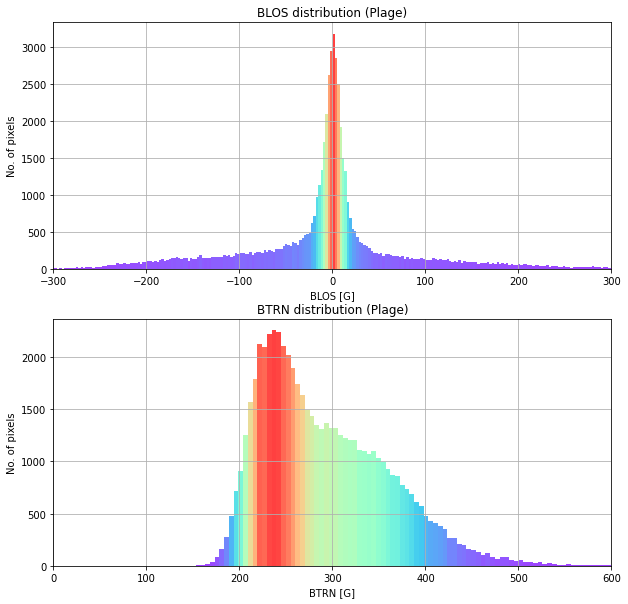

In [25]:
#
# OK, let's examine the distribution of WFA magnetic fields in the Plage region...
#

mpl.figure( figsize=[10,10] )

fig, (ax1, ax2) = mpl.subplots( 2, figsize=[10,10] )

n,bins,patches = ax1.hist( pl_blos.flatten(), bins="auto", align="mid", alpha=0.75 )
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(mpl.cm.rainbow(n[i]/max(n)))
ax1.set_xlim( -300, 300 )
ax1.set_title( "BLOS distribution (Plage)" )
ax1.set_xlabel( "BLOS [G]" )
ax1.set_ylabel( "No. of pixels" )
ax1.grid( True )

n,bins,patches = ax2.hist( pl_btrn.flatten(), bins="auto", align="mid", alpha=0.75 )
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(mpl.cm.rainbow(n[i]/max(n)))
ax2.set_xlim( 0, 600 )
ax2.set_title( "BTRN distribution (Plage)" )
ax2.set_xlabel( "BTRN [G]" )
ax2.set_ylabel( "No. of pixels" )
ax2.grid( True )

mpl.show( )

In [26]:
#
# OK, what about the Quiet-Sun?  Can we extract useful WFA results from high-noise spectropolarimetric signals?
#

nx = qs[1] - qs[0] + 1
ny = qs[3] - qs[2] + 1

qs_lam0 = np.zeros( (ny,nx) )
qs_blos = np.zeros( (ny,nx) )
qs_btrn = np.zeros( (ny,nx) )
qs_binc = np.zeros( (ny,nx) )
qs_bazm = np.zeros( (ny,nx) )

for y in tqdm(range(0,ny)):
    scan = qs[2] + y
    for x in range(0,nx):
        pix       = qs[0] + x
        data[0,:] = np.squeeze( si[:,scan,pix] )
        data[1,:] = np.squeeze( sq[:,scan,pix] )
        data[2,:] = np.squeeze( su[:,scan,pix] )
        data[3,:] = np.squeeze( sv[:,scan,pix] )
    
        lam0         = wfa.calc_lam0_cog( np.squeeze(data[0,ws:we]), wobs[ws:we], lam0_nom )
        wfaparms     = wfa.wfapprox( data, wobs, glos_eff, gtrn_eff, lam0 )
        qs_blos[y,x] = wfaparms[1]
        qs_btrn[y,x] = wfaparms[2]
        qs_binc[y,x] = wfaparms[4]
        qs_bazm[y,x] = wfaparms[5]
        qs_lam0[y,x] = lam0
    pass

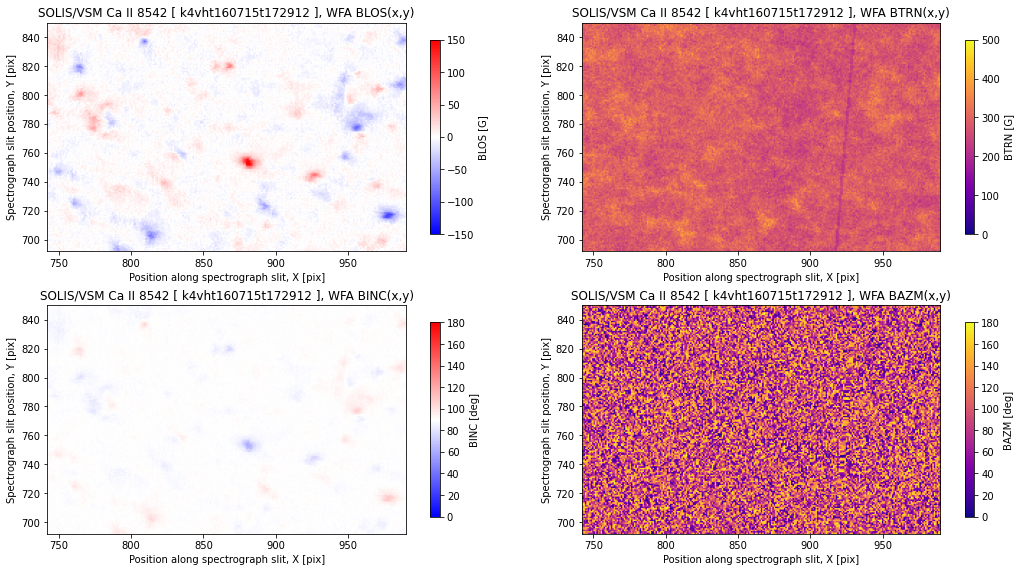

In [27]:
#
# Now, let's take a look at the WFA results (Quiet-Sun)!
#

fig, ((ax1, ax2), (ax3, ax4)) = mpl.subplots( 2, 2, figsize=[15,8] )

ax1.set_title( obsprefix + ", WFA BLOS(x,y)" )
ax1.set_xlabel( xlabel )
ax1.set_ylabel( ylabel )
im1   = ax1.imshow( qs_blos, origin="lower", cmap="bwr", vmin=-150, vmax=150, extent=qs )
cbar1 = mpl.colorbar( im1, ax=ax1, shrink=0.85 )
cbar1.set_label( "BLOS [G]") 

ax2.set_title( obsprefix + ", WFA BTRN(x,y)" )
ax2.set_xlabel( xlabel )
ax2.set_ylabel( ylabel )
im2   = ax2.imshow( qs_btrn, origin="lower", cmap="plasma", vmin=0, vmax=500, extent=qs )
cbar2 = mpl.colorbar( im2, ax=ax2, shrink=0.85 )
cbar2.set_label( "BTRN [G]") 

ax3.set_title( obsprefix + ", WFA BINC(x,y)" )
ax3.set_xlabel( xlabel )
ax3.set_ylabel( ylabel )
im3   = ax3.imshow( qs_binc, origin="lower", cmap="bwr", vmin=0, vmax=180, extent=qs )
cbar3 = mpl.colorbar( im3, ax=ax3, shrink=0.85 )
cbar3.set_label( "BINC [deg]") 

ax4.set_title( obsprefix + ", WFA BAZM(x,y)" )
ax4.set_xlabel( xlabel )
ax4.set_ylabel( ylabel )
im4   = ax4.imshow( qs_bazm, origin="lower", cmap="plasma", vmin=0, vmax=180, extent=qs )
cbar4 = mpl.colorbar( im4, ax=ax4, shrink=0.85 )
cbar4.set_label( "BAZM [deg]") 

mpl.tight_layout( )
mpl.show( )

#
# Here we see strong, mostly-vertical network fields at 1 arcsecond spatial resolution...
#

<Figure size 720x720 with 0 Axes>

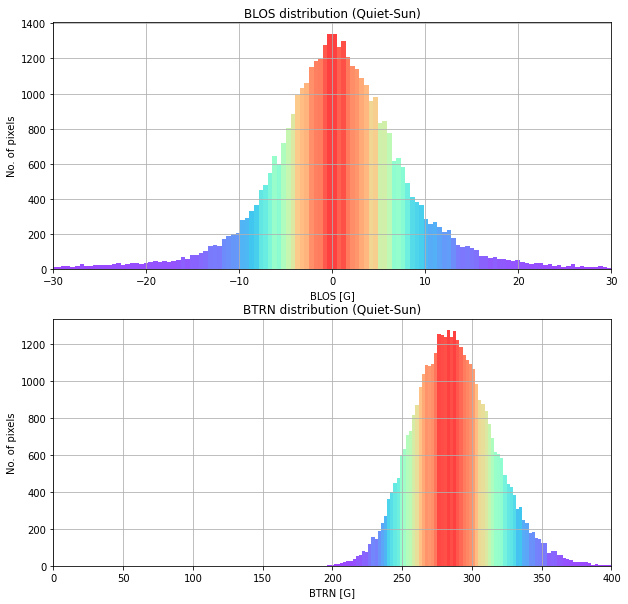

In [28]:
#
# OK, let's examine the distribution of WFA magnetic fields in the Quiet-Sun region...
#

mpl.figure( figsize=[10,10] )

fig, (ax1, ax2) = mpl.subplots( 2, figsize=[10,10] )

n,bins,patches = ax1.hist( qs_blos.flatten(), bins="auto", align="mid", alpha=0.75 )
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(mpl.cm.rainbow(n[i]/max(n)))
ax1.set_xlim( -30, 30 )
ax1.set_title( "BLOS distribution (Quiet-Sun)" )
ax1.set_xlabel( "BLOS [G]" )
ax1.set_ylabel( "No. of pixels" )
ax1.grid( True )

n,bins,patches = ax2.hist( qs_btrn.flatten(), bins="auto", align="mid", alpha=0.75 )
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(mpl.cm.rainbow(n[i]/max(n)))
ax2.set_xlim( 0, 400 )
ax2.set_title( "BTRN distribution (Quiet-Sun)" )
ax2.set_xlabel( "BTRN [G]" )
ax2.set_ylabel( "No. of pixels" )
ax2.grid( True )

mpl.show( )

#
# So, coherent small-scale Quiet-Sun features can be seen in BLOS, but are less
# substantially-visible in BTRN/BAZM...features are only *weakly* inclined w.r.t.
# observer's LOS.
#

#
# What can you conclude about difference in sensitivity to circular and linear
# polarization in the WFA?  Think first- and second-order effects...
#